<a href="https://colab.research.google.com/github/cesaroliveiragoes/Global_Solutions_Blue_Future_FIAP/blob/main/Global_Solutions_Rede_Neural.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Bibliotecas Importadas
import tensorflow as tf
import matplotlib.pyplot as plt
import os
import pandas as pd
import numpy as np

In [ ]:
# Criação das variáveis atreladas aos datasets de imagens
dataset_dir = os.path.join(os.getcwd(), 'oceano')

dataset_train_dir = os.path.join(dataset_dir, 'train')
dataset_train_poluicao_len = len(os.listdir(os.path.join(dataset_train_dir, 'poluicao')))
dataset_train_nao_poluicao_len = len(os.listdir(os.path.join(dataset_train_dir, 'nao_poluicao')))

dataset_validation_dir = os.path.join(dataset_dir, 'validation')
dataset_validation_poluicao_len = len(os.listdir(os.path.join(dataset_validation_dir, 'poluicao')))
dataset_validation_nao_poluicao_len = len(os.listdir(os.path.join(dataset_validation_dir, 'nao_poluicao')))

print('Train Poluicao: %s' % dataset_train_poluicao_len)
print('Train Não Poluicao: %s' % dataset_train_nao_poluicao_len)
print('Validation Poluicao: %s' % dataset_validation_poluicao_len)
print('Validation Não Poluicao: %s' % dataset_validation_nao_poluicao_len)

Train Poluicao: 45
Train Não Poluicao: 45
Validation Poluicao: 16
Validation Não Poluicao: 16


In [ ]:
# Redefinir o tamanho das imagens
image_width = 160
image_height = 160
image_color_channel = 3
image_color_channel_size = 255
image_size = (image_width, image_height)
image_shape = image_size + (image_color_channel,)

batch_size = 4
epochs = 20
learning_rate = 0.001

class_names = ['Não Poluído', 'Poluído']

In [ ]:
# Criar a variável dataset_train contendo todos as imagens para treino
dataset_train = tf.keras.preprocessing.image_dataset_from_directory(
    dataset_train_dir,
    image_size = image_size,
    batch_size = batch_size,
    shuffle = True
)

Found 90 files belonging to 2 classes.


In [ ]:
# Criar a variável dataset_validation contendo todas as imagens para treino
dataset_validation = tf.keras.preprocessing.image_dataset_from_directory(
    dataset_validation_dir,
    image_size = image_size,
    batch_size = batch_size,
    shuffle = True
)

Found 30 files belonging to 2 classes.


In [ ]:
# Criando o dataset_test a partir de uma parte do dataset de validação
dataset_validation_cardinality = tf.data.experimental.cardinality(dataset_validation)
dataset_validation_batches = dataset_validation_cardinality // 3 #passando a terça parte para o dataset

dataset_test = dataset_validation.take(dataset_validation_batches)
dataset_validation = dataset_validation.skip(dataset_validation_batches)

print('Validation Dataset Cardinality: %d' % tf.data.experimental.cardinality(dataset_validation))
print('Test Dataset Cardinality %d' % tf.data.experimental.cardinality(dataset_test))

Validation Dataset Cardinality: 6
Test Dataset Cardinality 2


In [ ]:
# função para plotar imagens dos datasets e analisar
def plot_dataset(dataset):

  plt.gcf().clear()
  plt.figure(figsize = (15, 15))

  for features, labels in dataset.take(1):

    for i in range(len(features)):

      plt.subplot(3, 3, i + 1)
      plt.axis('off')

      plt.imshow(features[i].numpy().astype('uint8'))
      plt.title(class_names[labels[i]])

<Figure size 640x480 with 0 Axes>

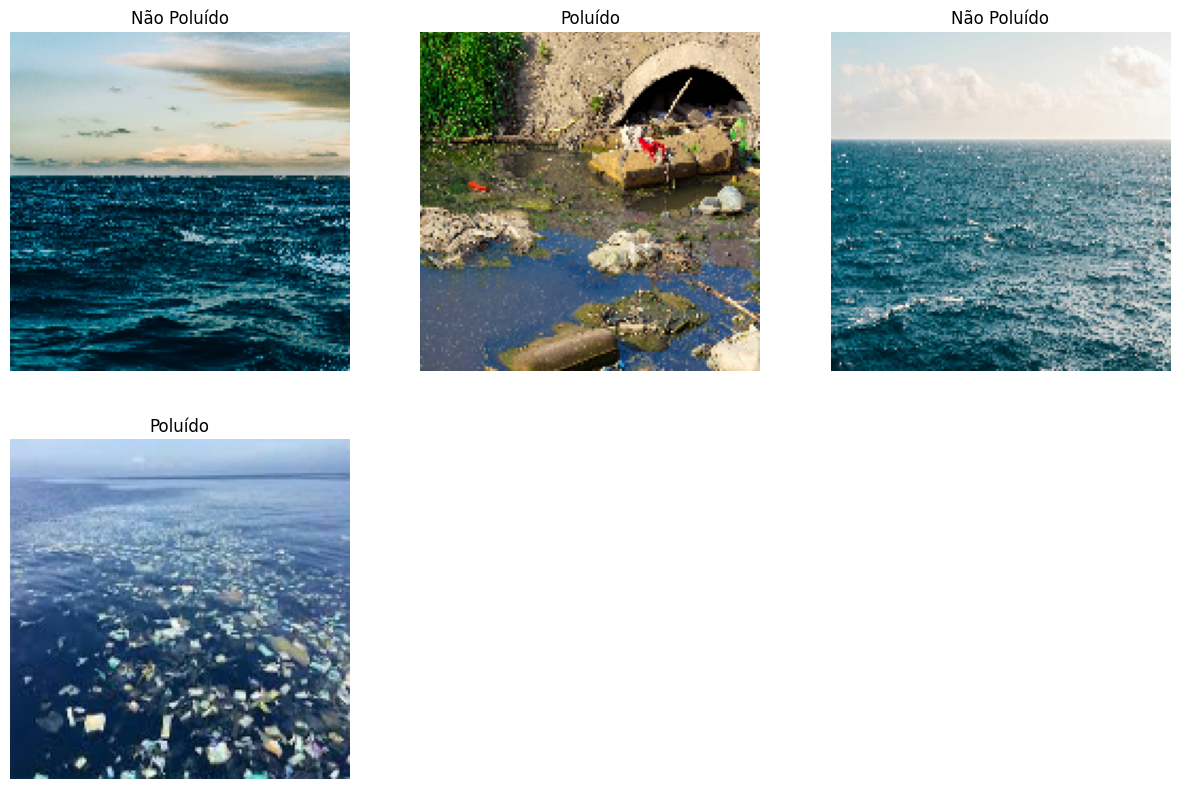

In [ ]:
plot_dataset(dataset_train)

<Figure size 640x480 with 0 Axes>

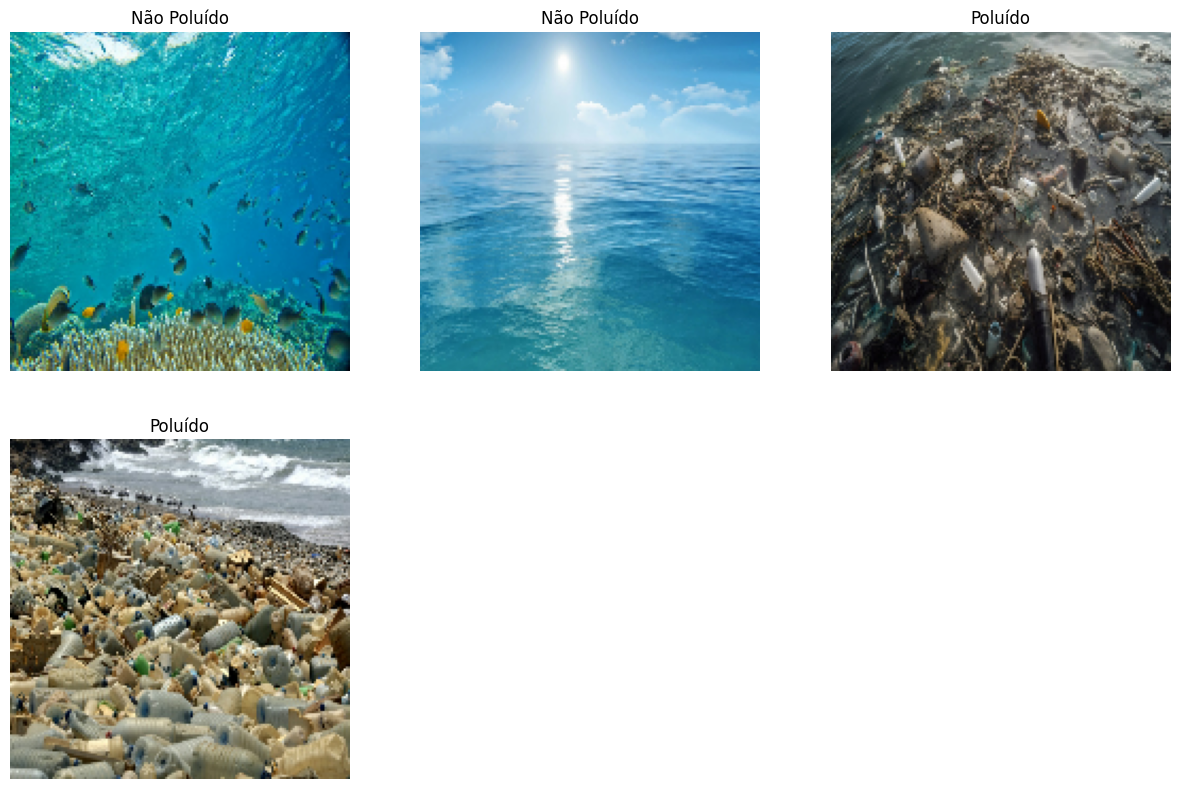

In [ ]:
plot_dataset(dataset_validation)

<Figure size 640x480 with 0 Axes>

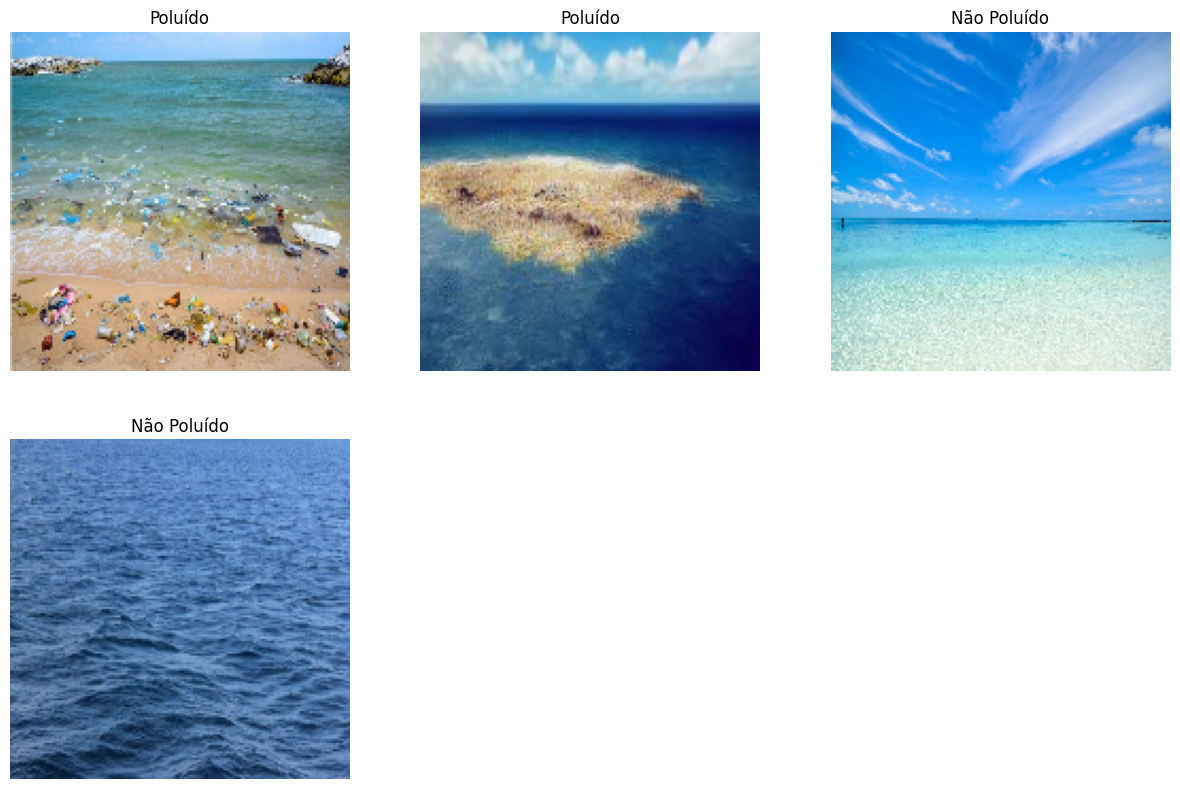

In [ ]:
plot_dataset(dataset_test)

In [ ]:
# Aprimoramento da análise das imagens, aqui, irá girar, dar zoom etc
data_augmentation = tf.keras.models.Sequential([
    tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal'),
    tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
    tf.keras.layers.experimental.preprocessing.RandomZoom(0.2)
])

In [ ]:
# função do aprimoramento das imagens
def plot_dataset_augmentation(dataset):

  plt.gcf().clear()
  plt.figure(figsize = (15, 15))

  for features, _ in dataset.take(1):
    feature = features[0]

    for i in range(len(features)):

      feature_data_augmentation = data_augmentation(tf.expand_dims(feature, 0))
      plt.subplot(3, 3, i + 1)
      plt.axis('off')

      plt.imshow(feature_data_augmentation[0] / image_color_channel_size)

<Figure size 640x480 with 0 Axes>

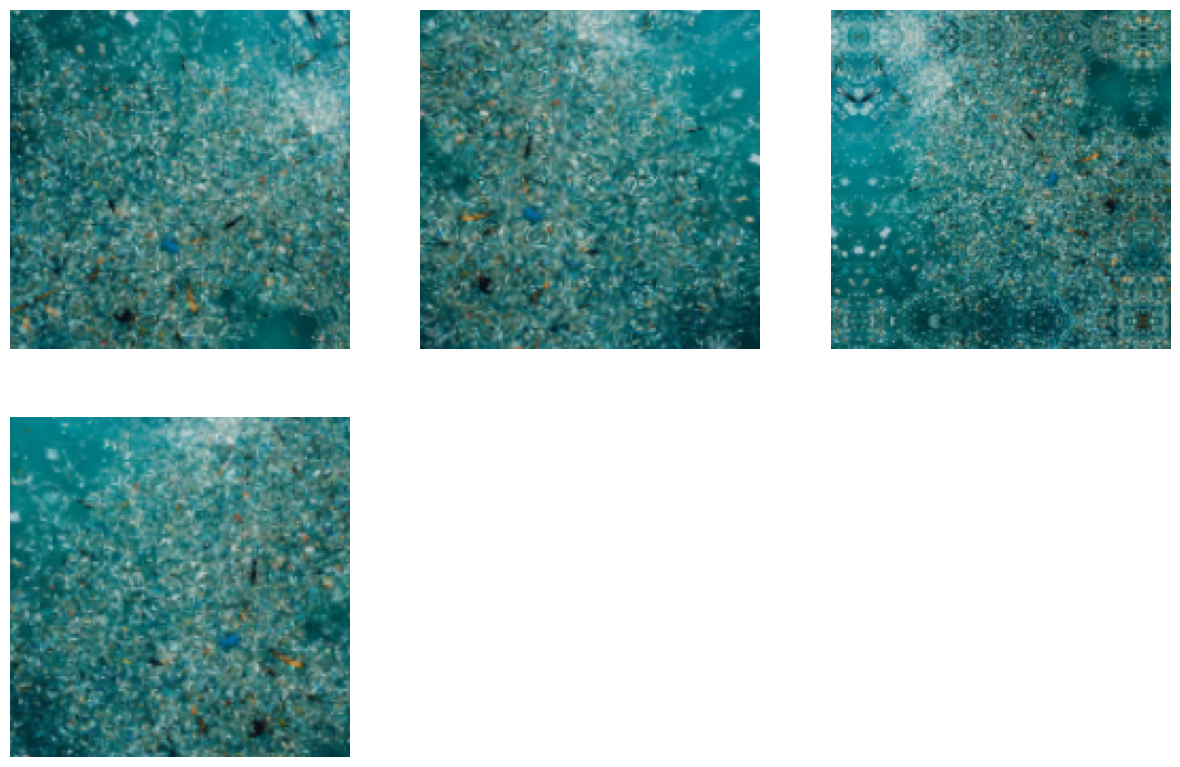

In [ ]:
plot_dataset_augmentation(dataset_test)

In [ ]:
# Aplicar modelo já treinado pel oTensorflow p/ aumentar a performance
model_transfer_learning = tf.keras.applications.MobileNetV2(
    input_shape = image_shape,
    include_top = False,
    weights = 'imagenet'
)

model_transfer_learning.trainable = False

model_transfer_learning.summary()

Model: "mobilenetv2_1.00_160"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 160, 160, 3)]        0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 80, 80, 32)           864       ['input_3[0][0]']             
                                                                                                  
 bn_Conv1 (BatchNormalizati  (None, 80, 80, 32)           128       ['Conv1[0][0]']               
 on)                                                                                              
                                                                                                  
 Conv1_relu (ReLU)           (None, 80, 80, 32)           0         ['bn_Conv1[

In [ ]:
model = tf.keras.models.Sequential([
    tf.keras.layers.experimental.preprocessing.Rescaling(
        1. / (image_color_channel_size / 2),
        offset = -1,
        input_shape = image_shape
    ),
    data_augmentation,
    model_transfer_learning,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(1, activation = 'sigmoid')
])

model.compile(
    optimizer = tf.keras.optimizers.Adam(learning_rate = learning_rate),
    loss = tf.keras.losses.BinaryCrossentropy(),
    metrics = ['accuracy']
)

model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_3 (Rescaling)     (None, 160, 160, 3)       0         
                                                                 
 sequential_6 (Sequential)   (None, 160, 160, 3)       0         
                                                                 
 mobilenetv2_1.00_160 (Func  (None, 5, 5, 1280)        2257984   
 tional)                                                         
                                                                 
 global_average_pooling2d_3  (None, 1280)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dropout_3 (Dropout)         (None, 1280)              0         
                                                                 
 dense_3 (Dense)             (None, 1)                

In [ ]:
# Observar o avanço do treinamento
history = model.fit(
    dataset_train,
    validation_data = dataset_validation,
    epochs = epochs
)

Epoch 1/20
23/23 [==============================] - 13s 289ms/step - loss: 0.7103 - accuracy: 0.6111 - val_loss: 0.5697 - val_accuracy: 0.6818
Epoch 2/20
23/23 [==============================] - 9s 267ms/step - loss: 0.5474 - accuracy: 0.7444 - val_loss: 0.4881 - val_accuracy: 0.8182
Epoch 3/20
23/23 [==============================] - 7s 200ms/step - loss: 0.4276 - accuracy: 0.8444 - val_loss: 0.4781 - val_accuracy: 0.7273
Epoch 4/20
23/23 [==============================] - 9s 198ms/step - loss: 0.4359 - accuracy: 0.8000 - val_loss: 0.4633 - val_accuracy: 0.7727
Epoch 5/20
23/23 [==============================] - 9s 282ms/step - loss: 0.3416 - accuracy: 0.8222 - val_loss: 0.3807 - val_accuracy: 0.8636
Epoch 6/20
23/23 [==============================] - 7s 203ms/step - loss: 0.3275 - accuracy: 0.8778 - val_loss: 0.4346 - val_accuracy: 0.8182
Epoch 7/20
23/23 [==============================] - 7s 200ms/step - loss: 0.2804 - accuracy: 0.9111 - val_loss: 0.4629 - val_accuracy: 0.8182
Epoch

In [ ]:
# Função para plotar a performance do treinamento e validação
def plot_model():

  accuracy = history.history['accuracy']
  val_accuracy = history.history['val_accuracy']

  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs_range = range(epochs)

  plt.gcf().clear()
  plt.figure(figsize = (15, 8))

  plt.subplot(1, 2, 1)
  plt.title('Treinamento e Vlidação Acurácia')
  plt.plot(epochs_range, accuracy, label = 'Treinamento Acurácia')
  plt.plot(epochs_range, val_accuracy, label = 'Validação Acurácia')
  plt.legend(loc = 'lower right')

  plt.subplot(1, 2, 2)
  plt.title('Treinamento e Vlidação Perda')
  plt.plot(epochs_range, loss, label = 'Treinamento Perda')
  plt.plot(epochs_range, val_loss, label = 'Validação Perda')
  plt.legend(loc = 'lower right')

  plt.show()

<Figure size 640x480 with 0 Axes>

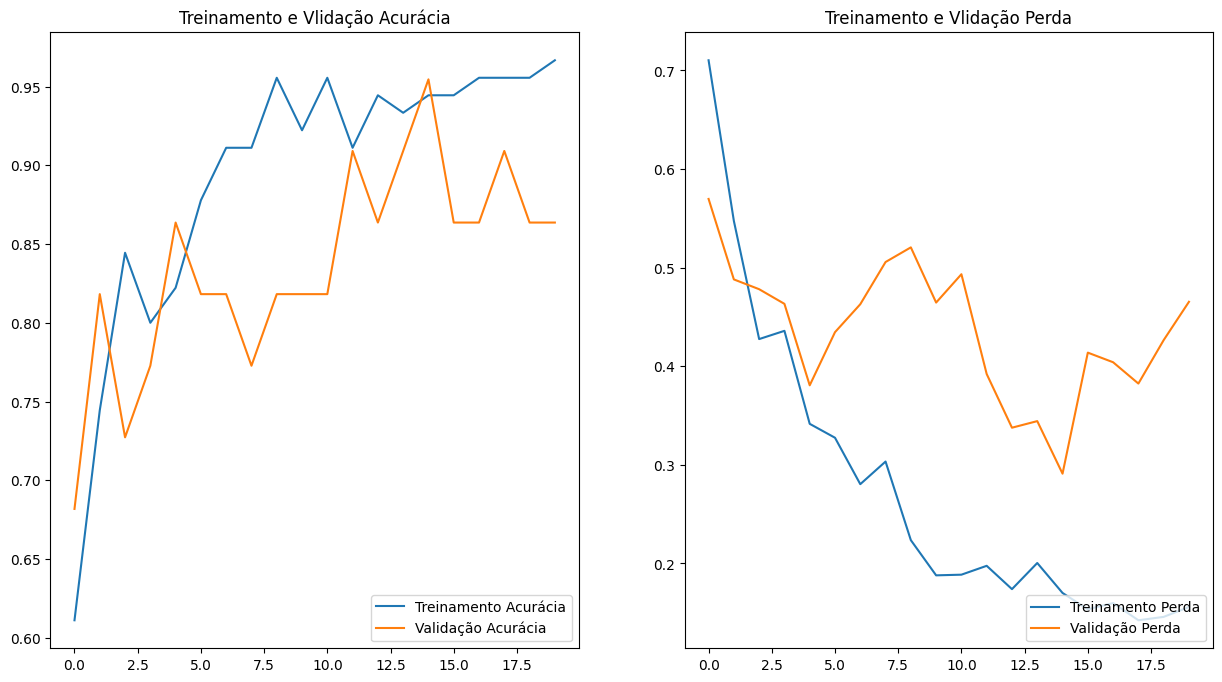

In [ ]:
plot_model()

In [ ]:
# Analisar o dataset novo que o algoritimo não tinha visto ainda
def plot_dataset_predictions(dataset):

  iterator = dataset.as_numpy_iterator()

  while True:
    try:
      features, labels = iterator.next()
      predictions = model.predict(features).flatten()
      predictions = tf.where(predictions <0.5, 0, 1)

      print('Labels:      %s' % labels)
      print('Predictions: %s' % predictions.numpy())

      plt.gcf().clear()
      plt.figure(figsize = (15, 15))

      for i in range(len(features)):
        plt.subplot(3, 3, i + 1)
        plt.axis('off')
        plt.imshow(features[i].astype('uint8'))
        plt.title(class_names[predictions[i]])
    except StopIteration:
      break

1/1 [==============================] - 1s 951ms/step
Labels:      [1 0 0 0]
Predictions: [1 1 0 0]
1/1 [==============================] - 0s 130ms/step
Labels:      [1 1 0 1]
Predictions: [1 1 0 1]


<Figure size 640x480 with 0 Axes>

<Figure size 1500x1500 with 0 Axes>

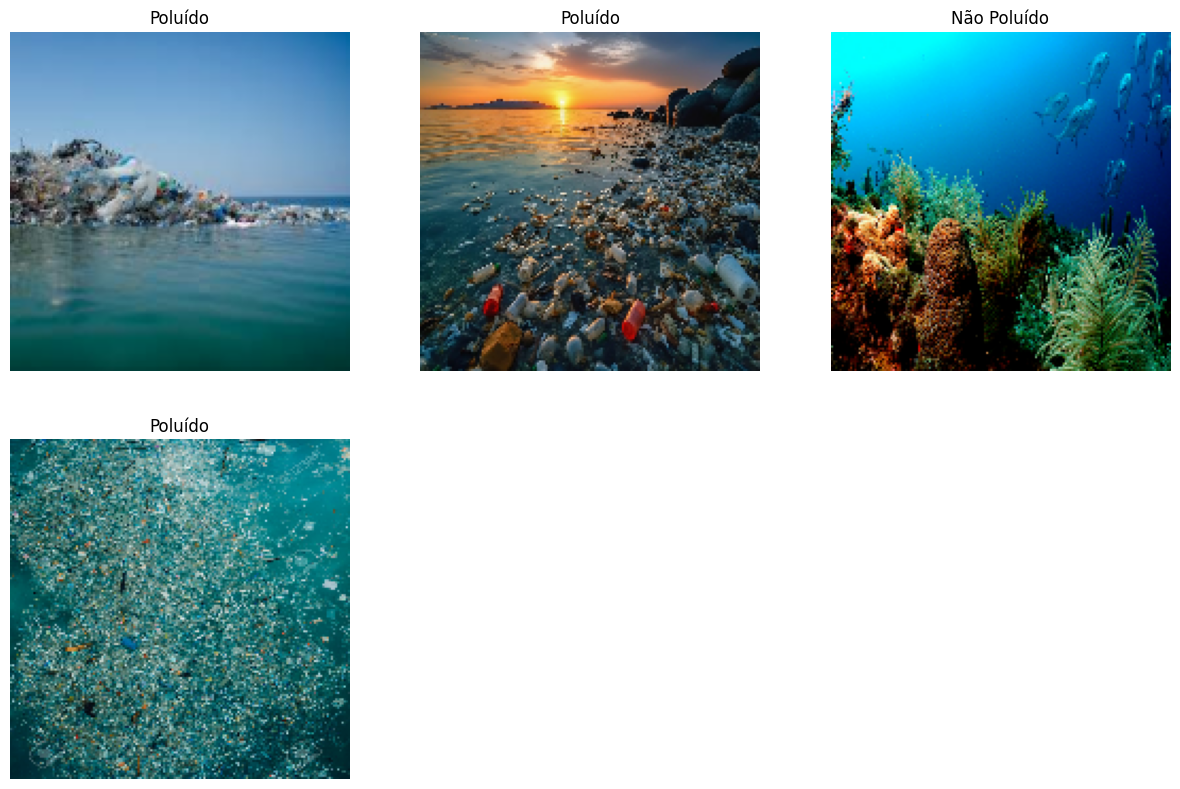

In [ ]:
plot_dataset_predictions(dataset_test)